In [1]:
import pandas as pd
import glob
import ta
import os
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
#plt.style.use('seaborn-deep')
import numpy as np
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import itertools
from collections import Counter
import math
from numba import jit
#import asyncio
import heapq
                                 
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)

In [2]:
# current_dir = os.getcwd()
# print(f"Current working directory: {current_dir}")

In [3]:
data = pd.read_csv('/Users/denislukanov/Desktop/Trading/data/temp/BTCUSDT-aggTrades-2024-04.csv')

In [4]:
data['transact_time'] = pd.to_datetime(data['transact_time'], unit='ms')

In [5]:
data

,agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
0,2108276933,71363.0,0.840,4819675588,4819675603,2024-04-01 00:00:00.010,False
1,2108276934,71362.9,0.024,4819675604,4819675604,2024-04-01 00:00:00.029,True
2,2108276935,71363.0,0.011,4819675605,4819675605,2024-04-01 00:00:00.108,False
3,2108276936,71362.9,0.034,4819675606,4819675611,2024-04-01 00:00:00.148,True
4,2108276937,71363.0,0.200,4819675612,4819675612,2024-04-01 00:00:00.184,False
...,...,...,...,...,...,...,...
52506242,2160783175,60651.2,0.967,4954845120,4954845122,2024-04-30 23:59:58.906,False
52506243,2160783176,60651.1,0.003,4954845123,4954845123,2024-04-30 23:59:59.029,True
52506244,2160783177,60651.1,0.082,4954845124,4954845129,2024-04-30 23:59:59.132,True
52506245,2160783178,60651.2,0.003,4954845130,4954845130,2024-04-30 23:59:59.574,False


In [6]:
# Code to make necessary timeframe(TF)slices from the raw Aggtrade data
@jit(nopython=True)
def calculate_slice_stats(slice_data):
    slice_high = np.max(slice_data['price'])
    slice_low = np.min(slice_data['price'])
    slice_open = slice_data['price'][0] if len(slice_data['price']) > 0 else 0
    slice_close = slice_data['price'][-1] if len(slice_data['price']) > 0 else 0
    slice_volume = np.sum(slice_data['quantity'])
    #slice_q_volume = np.sum(slice_data['quantity'] * slice_close) if len(slice_data['price']) > 0 else 0
    return slice_high, slice_low, slice_open, slice_close, slice_volume#, slice_q_volume

def candles_slices_without_mult(df, slice_period):
    df['timestamp'] = pd.to_datetime(df['transact_time'], format='%Y-%m-%d %H:%M:%S.%f') 
    #df = df.drop_duplicates(subset=['timestamp'], keep='last') 

    # Group by timestamp and calculate the required statistics
    grouped_df = df.groupby(pd.Grouper(key='timestamp', freq=f'{slice_period}S', closed='left')).agg(
        high=('price', 'max'),
        low=('price', 'min'),
        open=('price', 'first'),
        close=('price', 'last'),
        volume=('quantity', 'sum'),
        #quoted_volume=('price', lambda x: (x * x.iloc[-1]).sum() if len(x) > 0 else 0)
    )

    return grouped_df

In [7]:
# slice period set to 1 sec (could be changed)

In [8]:
%%time
combined_df_big = candles_slices_without_mult(data, 1)

CPU times: user 10.4 s, sys: 2.11 s, total: 12.5 s
Wall time: 12.5 s


In [9]:
combined_df_big['d_v'] = combined_df_big['close']*combined_df_big['volume']

In [10]:
df_reset = combined_df_big.reset_index()

df_reset.rename(columns={'index': 'timestamp'}, inplace=True)

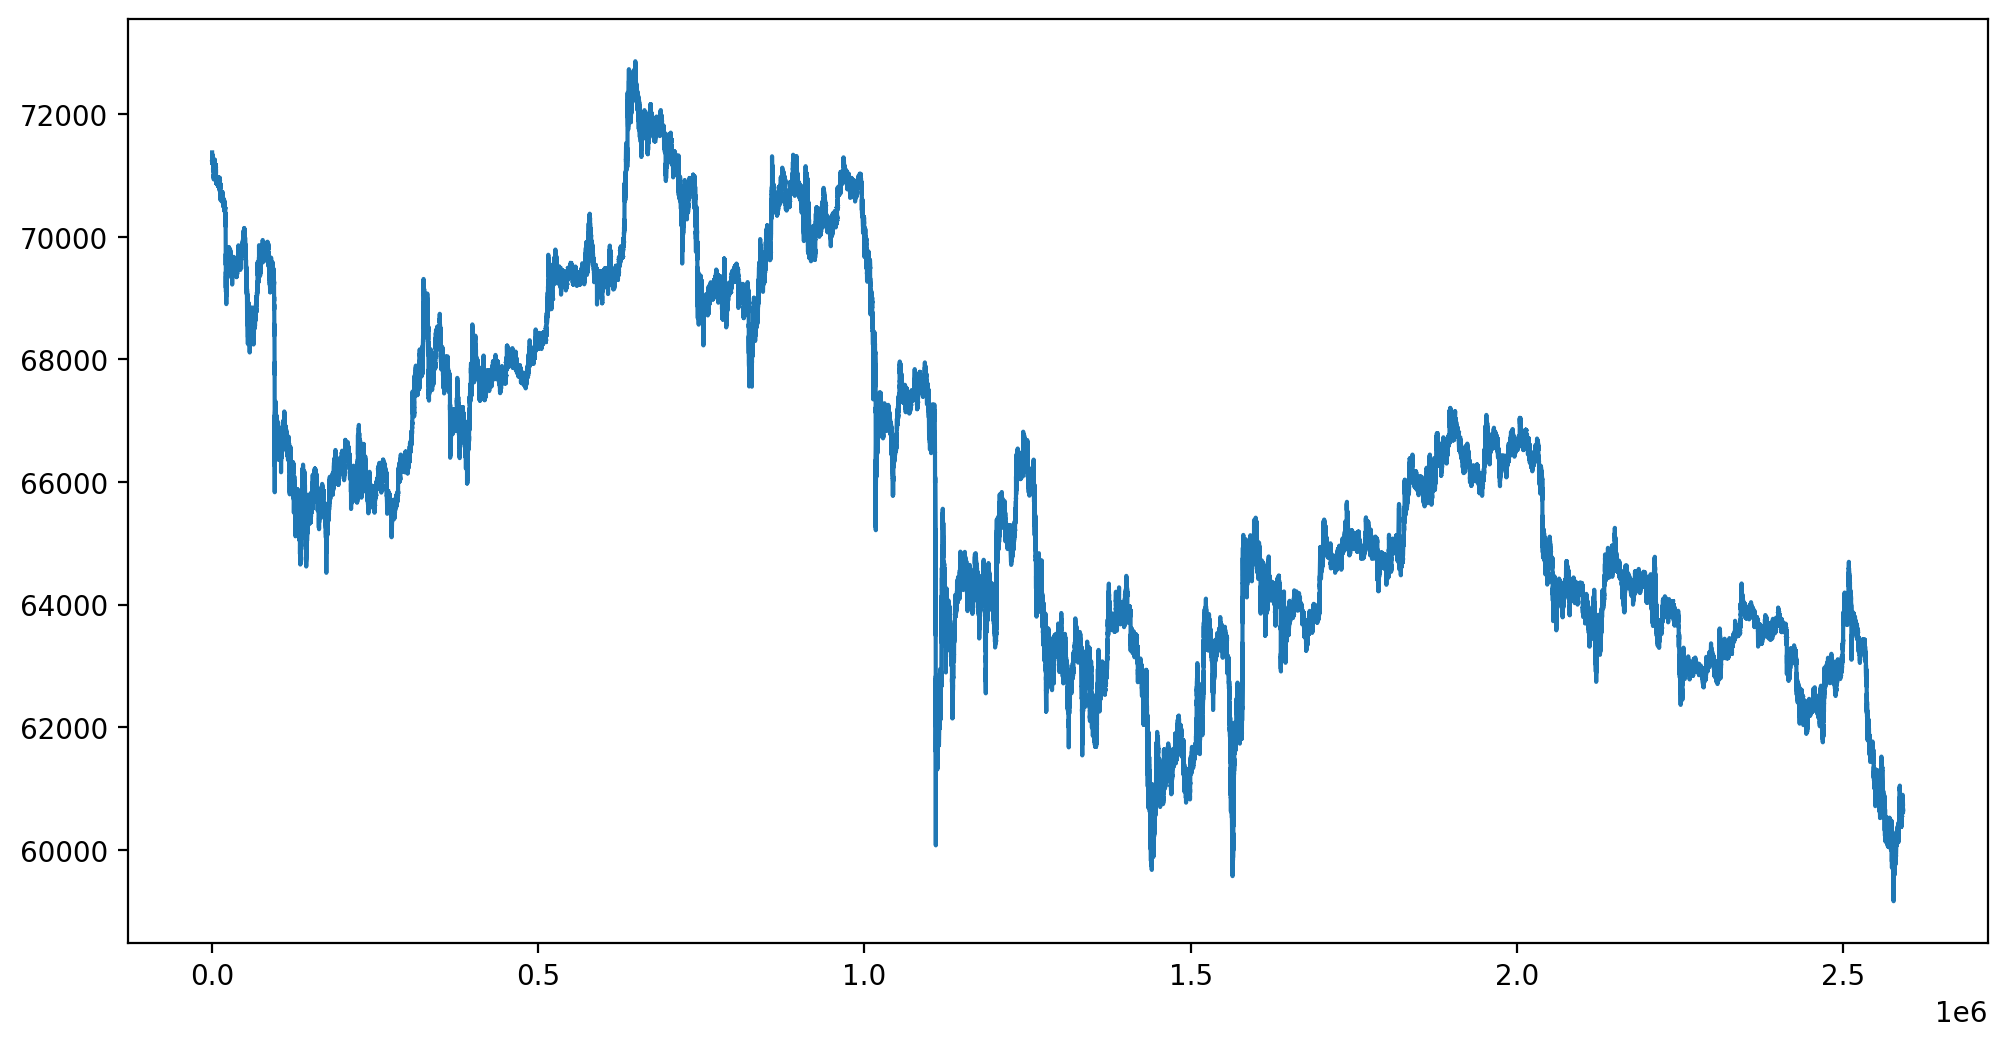

In [11]:
plt.figure(figsize=(12, 6))
df_reset.close.plot()
plt.show();

In [12]:
df = df_reset

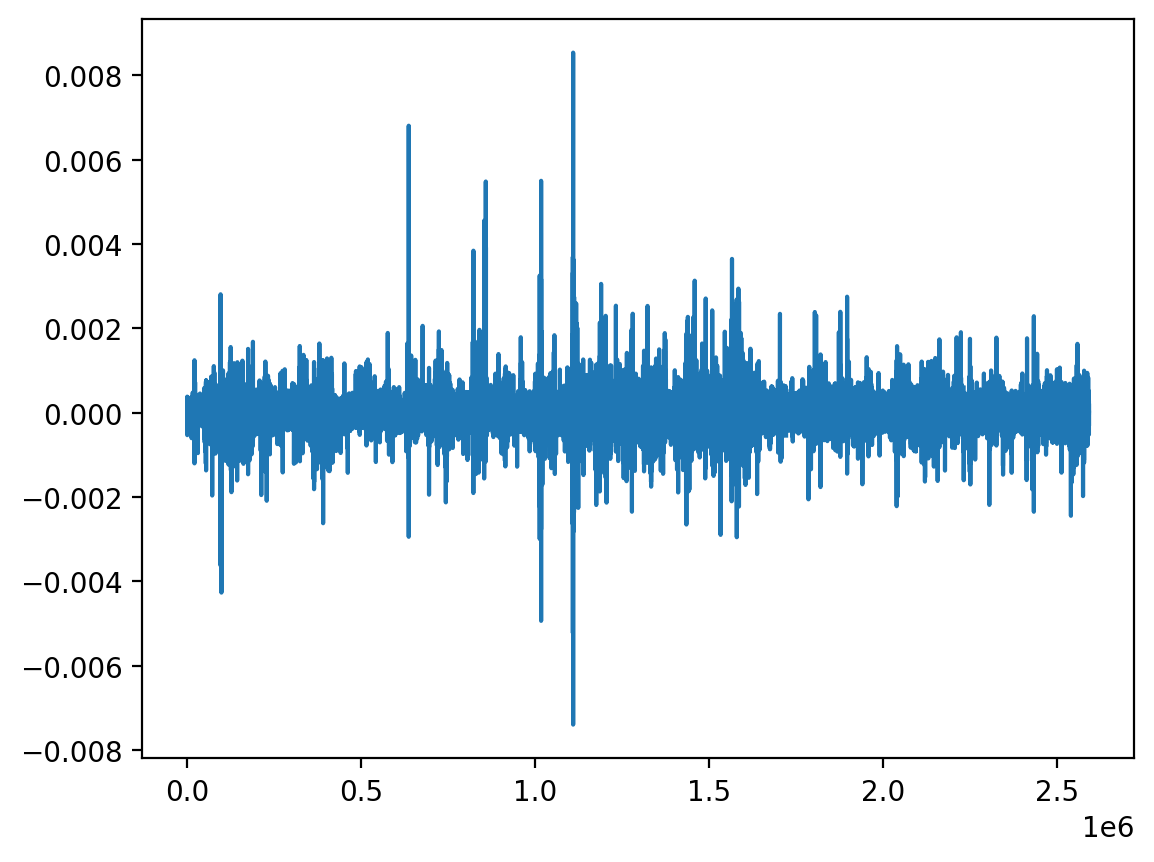

In [13]:
df['LogRet'] = np.log(df['close']).diff()
d_p =df['LogRet'] 
d_p.plot();

In [14]:
#check for Nans
nan_count = np.sum(np.isnan(d_p))

print(f"Number of NaNs in d_p: {nan_count}")

Number of NaNs in d_p: 50799


In [15]:
# interpolate missing prices
d_p_interpolated = d_p.interpolate(method='linear')

d_p_filled = d_p_interpolated.to_numpy()

print("Array after filling NaNs with linear interpolation:")
print(d_p_filled)

Array after filling NaNs with linear interpolation:
[            nan             nan             nan ...  2.12711754e-04
 -1.15413374e-05  0.00000000e+00]


In [16]:
vol = df['volume']

In [17]:
# check for Nans
nan_count = np.sum(np.isnan(d_p_filled))
print(f"Number of NaNs in d_p_filled: {nan_count}")

Number of NaNs in d_p_filled: 5


In [18]:
d_p = d_p_filled[1:]
vol = df['volume'][1:]

In [19]:
#input parameters 

d_p = d_p # log returns
vol = df['d_v'] # dollar volumes
span = 2 # span for exponential
threshold = 100*np.mean(vol) # treshhold set up

d_p = np.nan_to_num(d_p, nan=0.0)
vol = np.nan_to_num(vol, nan=0.0)

### Main algorithm implementation 

In [20]:
'''
The code implements the profound ideas from the book "Advances in Financial Machine Learning" by 
Marcos López de Prado and calculates time-to-reach of the treshhold based on USD_volume and tick imbalance

The logic is the following: higher imbalance => lower time-to-reach

JIT helps a lot with speed of :)
'''

'\nThe code implements the profound ideas from the book "Advances in Financial Machine Learning" by \nMarcos López de Prado and calculates time-to-reach of the treshhold based on USD_volume and tick imbalance\n\nThe logic is the following: higher imbalance => lower time-to-reach\n\nJIT helps a lot with speed of :)\n'

In [21]:
%%time
@jit(nopython=True)
def create_b(d_p):
    n = len(d_p)
    b = np.empty(n, dtype=np.int32) 
    b_p = np.empty(n, dtype=np.int32) 
    b_m = np.empty(n, dtype=np.int32)    
    for i in range(n):
        if d_p[i] >= 0.001:
            b[i],b_p[i],b_m[i] = 1,1,0
        elif d_p[i] <= -0.001:
            b[i],b_p[i],b_m[i] = -1,0,-1
        else:
            if i == 0:
                b[i],b_p[i],b_m[i] = 1,1,0
            else:
                b[i],b_p[i],b_m[i] = b[i - 1],b_p[i-1],b_m[i-1]
    return b,b_p,b_m

b, b_p, b_m = create_b(d_p)

@jit(nopython=True)
def exponential_moving_average(data, span):
    alpha = 2 / (span + 1)
    ema_values = []
    ema_values.append(data[0]) 

    for i in range(1, len(data)):
        ema = (alpha * data[i]) + ((1 - alpha) * ema_values[i - 1])
        ema_values.append(ema)

    return ema_values


def calculate_probabilities(b,b_p,b_m):
    n = len(b)
    
    P_positive = exponential_moving_average(b_p,span) if n > 0 else 0
    P_negative = exponential_moving_average(b_m,span) if n > 0 else 0
    
    return P_positive, P_negative

P_positive,P_negative =  calculate_probabilities(b,b_p,b_m)

@jit(nopython=True)
def calculate_tm(d_p, b, vol, threshold):
    tm_v = []
    n = len(d_p)
    
    for i in range(n):
        theta_cp = 0
        theta_cn = 0
        for j in range(i, n):
            if b[j] > 0:
                theta_cp += b[j] * vol[j]
            else:
                theta_cn += -b[j] * vol[j]
            theta_c = max(theta_cp, theta_cn)
            if theta_c >= threshold:
                tm_v.append(j - i + 1)
                break
    return tm_v

tm_v = calculate_tm(d_p, b, vol, threshold)


def calculate_mean_tm(tm_v,span):
    n = len(tm_v)
    mean_tm_v = exponential_moving_average(tm_v,span) if n > 0 else 0
    return mean_tm_v

mean_tm_v=calculate_mean_tm(tm_v,span)

@jit(nopython=True)
def prob_theta(mean_tm_v, P_positive,P_negative):
    prob_theta = []
    for i in range(len(mean_tm_v)):
        prob_theta.append(max(P_positive[i],P_negative[i])*mean_tm_v[i])
    return prob_theta

prob_theta = prob_theta(mean_tm_v, P_positive,P_negative)

@jit(nopython=True)
def tm_prob(mean_tm_v,b, vol, prob_theta):
    tm_prob=[]
    for i in range(len(mean_tm_v)):
        j=i
        theta_cp,theta_cn=0,0
        while j<len(b):
            if b[j]>0:
                theta_cp+=b[j]* vol[j]
            else:
                theta_cn+=-b[j]* vol[j]
            theta_c=max(theta_cp,theta_cn)    
            if abs(theta_c)>=prob_theta[i]:
                tm_prob.append(j-i+1)
                break
            j+=1 
    return tm_prob

CPU times: user 10.9 s, sys: 185 ms, total: 11.1 s
Wall time: 11.1 s


In [22]:
tm_prob = tm_prob(mean_tm_v,b, vol, prob_theta)
rounded_val = list(map(round, tm_prob))

In [23]:
df

,timestamp,high,low,open,close,volume,d_v,LogRet
0,2024-04-01 00:00:00,71363.0,71362.9,71363.0,71363.0,1.145,8.171063e+04,NaN
1,2024-04-01 00:00:01,NaN,NaN,NaN,NaN,0.000,NaN,NaN
2,2024-04-01 00:00:02,71363.0,71362.9,71363.0,71362.9,0.098,6.993564e+03,NaN
3,2024-04-01 00:00:03,NaN,NaN,NaN,NaN,0.000,NaN,NaN
4,2024-04-01 00:00:04,71387.2,71362.9,71363.0,71377.2,15.354,1.095926e+06,NaN
...,...,...,...,...,...,...,...,...
2591995,2024-04-30 23:59:55,60657.9,60655.5,60655.5,60657.9,1.005,6.096119e+04,0.000041
2591996,2024-04-30 23:59:56,60657.9,60639.0,60657.8,60639.0,52.873,3.206166e+06,-0.000312
2591997,2024-04-30 23:59:57,60654.4,60639.1,60639.1,60651.9,16.070,9.746760e+05,0.000213
2591998,2024-04-30 23:59:58,60651.2,60651.1,60651.1,60651.2,0.975,5.913492e+04,-0.000012


In [24]:
price = df['close']
price_interpolated = price.interpolate(method='linear')

price_filled = price_interpolated.to_numpy()

print("Array after filling NaNs with linear interpolation:")
print(price_filled)

Array after filling NaNs with linear interpolation:
[71363.   71362.95 71362.9  ... 60651.9  60651.2  60651.2 ]


In [25]:
price = price_filled[1:]

In [26]:
# Regulate timestamps for the plot
start = 500000
end = 1200000

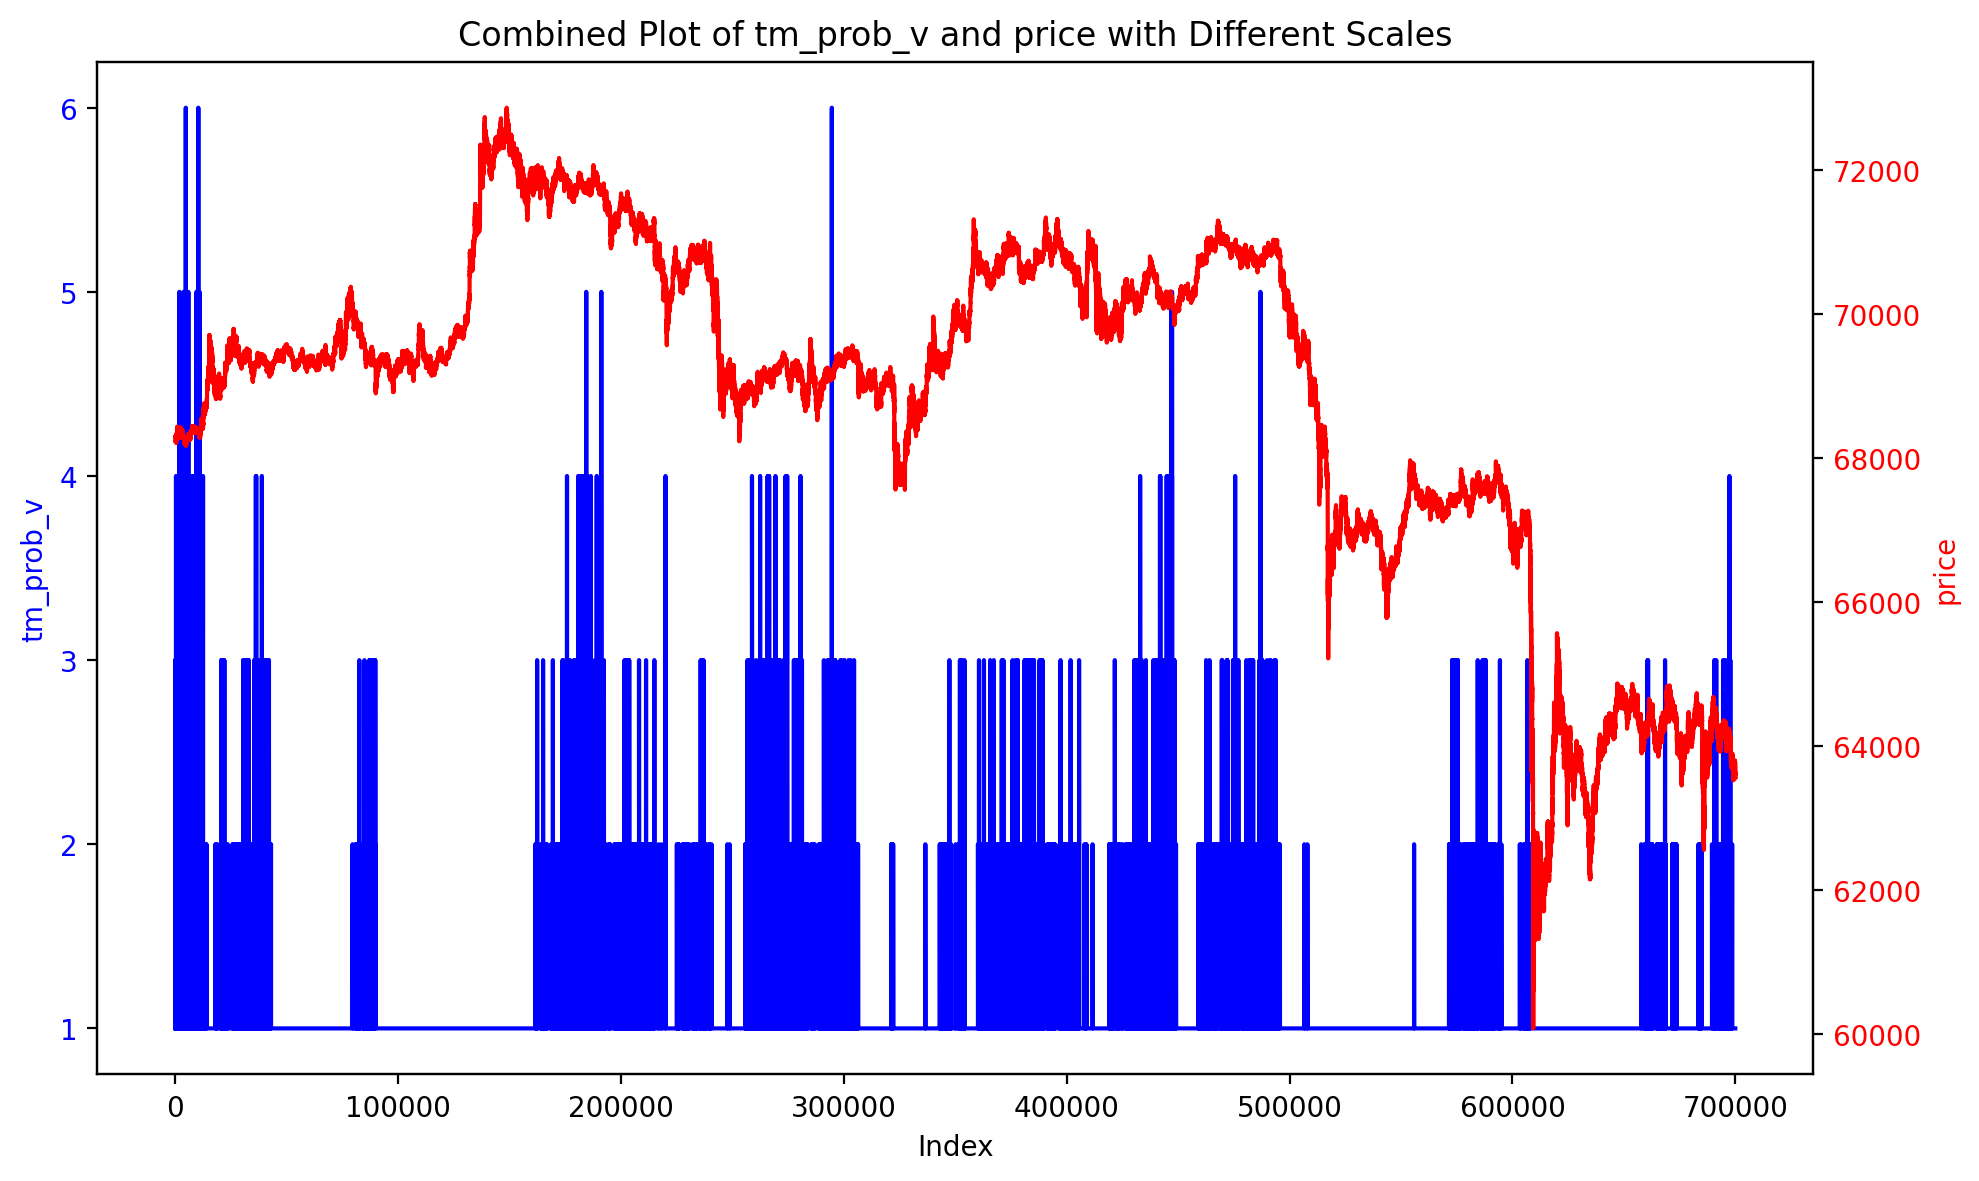

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(rounded_val[start:end], color='b', label='tm_prob_v')
ax1.set_xlabel('Index')  
ax1.set_ylabel('tm_prob_v', color='b') 
ax1.tick_params(axis='y', labelcolor='b') 

ax2 = ax1.twinx() 
ax2.plot(price[start:end], color='r', label='price')
ax2.set_ylabel('price', color='r')  
ax2.tick_params(axis='y', labelcolor='r')  

plt.title('Combined Plot of tm_prob_v and price with Different Scales')
fig.tight_layout() 
plt.show()

In [28]:
# Breakdown of time_thresholds counts
cnt = Counter(rounded_val[start:end])
cnt

Counter({1: 690516, 2: 8686, 3: 681, 4: 99, 5: 15, 6: 3})